In [2]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Set the path to the folder containing the CSV files
folder_path = '/Downloads/Mini Project TY Final FILES/godsplan1'

# Initialize an empty dictionary to store country-wise DataFrames
country_dfs = {}

# List all files in the folder
files = os.listdir(folder_path)

# Iterate through each file
for file in files:
    # Check if the file is a CSV file
    if file.endswith('.csv'):
        # Extract the country code from the file name (assuming it's the first two characters)
        country_code = file[:2]

        # Construct the full path to the CSV file
        file_path = os.path.join(folder_path, file)

        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Store the DataFrame in the dictionary with the country code as the key
        country_dfs[country_code] = df

# Print the number of DataFrames and the country codes
print("Number of DataFrames:", len(country_dfs))
print("Country Codes:", list(country_dfs.keys()))

Number of DataFrames: 28
Country Codes: ['EE', 'CZ', 'DK', 'BE', 'LV', 'AT', 'BG', 'LT', 'GR', 'PL', 'NO', 'FR', 'IT', 'HR', 'IE', 'FI', 'DE', 'HU', 'SK', 'GB', 'LU', 'SI', 'RO', 'CH', 'PT', 'ES', 'SE', 'NL']


In [3]:
target_columns = [
    'COP_ASHP_floor', 'COP_ASHP_radiator', 'COP_ASHP_water',
    'COP_GSHP_floor', 'COP_GSHP_radiator', 'COP_GSHP_water',
    'COP_WSHP_floor', 'COP_WSHP_radiator',
    'heat_demand_space', 'heat_demand_space_COM', 'heat_demand_space_MFH', 'heat_demand_space_SFH',
    'heat_demand_total', 'heat_demand_water', 'heat_demand_water_COM', 'heat_demand_water_MFH', 'heat_demand_water_SFH',
    'heat_profile_space_COM', 'heat_profile_space_MFH', 'heat_profile_space_SFH',
    'heat_profile_water_COM', 'heat_profile_water_MFH', 'heat_profile_water_SFH'
]


In [4]:
def generate_future_features(country_dfs, years=10):
    future_features_dict = {}

    for country_code, country_df in country_dfs.items():
        # Extract the last timestamp in the historical data
        last_timestamp = country_df['cet_cest_timestamp'].max()

        # Generate future timestamps for the specified number of years
        future_timestamps = pd.date_range(last_timestamp, periods=365 * years * 24, freq='H')[1:]

        # Create a DataFrame with future timestamps and corresponding day, month, year, and hour
        future_features = pd.DataFrame({
            'day': future_timestamps.day,
            'month': future_timestamps.month,
            'year': future_timestamps.year,
            'hour': future_timestamps.hour
        })

        future_features_dict[country_code] = future_features

    return future_features_dict

In [5]:
future_features_dict = generate_future_features(country_dfs, years=15)

In [6]:
def generate_predictions(country_dfs, future_features_dict, target_columns, years=10):
    predicted_dfs = {}

    for country_code, country_df in country_dfs.items():
        # Extract relevant features and target variables for the country
        features = country_df[['day', 'month', 'year', 'hour']]

        # Check which target columns are present in the dataframe
        present_target_columns = [col for col in target_columns if col in country_df.columns]

        if not present_target_columns:
            print(f"No target columns found for {country_code}. Skipping...")
            continue

        # Load corresponding future features
        future_features = future_features_dict[country_code]

        # Normalize or scale features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Build a linear regression model
        model = LinearRegression()

        # Train the model on the entire historical data for the specified target columns
        model.fit(features_scaled, country_df[present_target_columns])

        # Generate future predictions using the trained model
        future_features_scaled = scaler.transform(future_features)
        future_predictions = model.predict(future_features_scaled)

        # Create a DataFrame for the predictions, including the original features columns
        predictions_df = pd.DataFrame(future_predictions, columns=present_target_columns)
        predictions_df[['day', 'month', 'year', 'hour']] = future_features[['day', 'month', 'year', 'hour']]
        
        # Save the predictions DataFrame in the predicted_dfs dictionary, named according to the country code
        predicted_dfs[f"{country_code}_predicted_df"] = predictions_df

    return predicted_dfs

In [8]:
country_predicted_dfs = generate_predictions(country_dfs, future_features_dict, target_columns, years=15)

In [35]:
austria_predicted_df = country_predicted_dfs['AT_predicted_df']

In [36]:
print(austria_predicted_df.head(15))

    COP_ASHP_floor  COP_ASHP_radiator  COP_ASHP_water  COP_GSHP_floor  \
0         3.844614           3.741768        2.811424        5.437390   
1         3.844697           3.741955        2.811393        5.437497   
2         3.844781           3.742143        2.811361        5.437604   
3         3.844865           3.742330        2.811330        5.437711   
4         3.844949           3.742518        2.811299        5.437819   
5         3.845033           3.742706        2.811267        5.437926   
6         3.845116           3.742893        2.811236        5.438033   
7         3.845200           3.743081        2.811205        5.438140   
8         3.845284           3.743268        2.811173        5.438247   
9         3.845368           3.743456        2.811142        5.438355   
10        3.845452           3.743644        2.811111        5.438462   
11        3.845535           3.743831        2.811079        5.438569   
12        3.845619           3.744019        2.8110

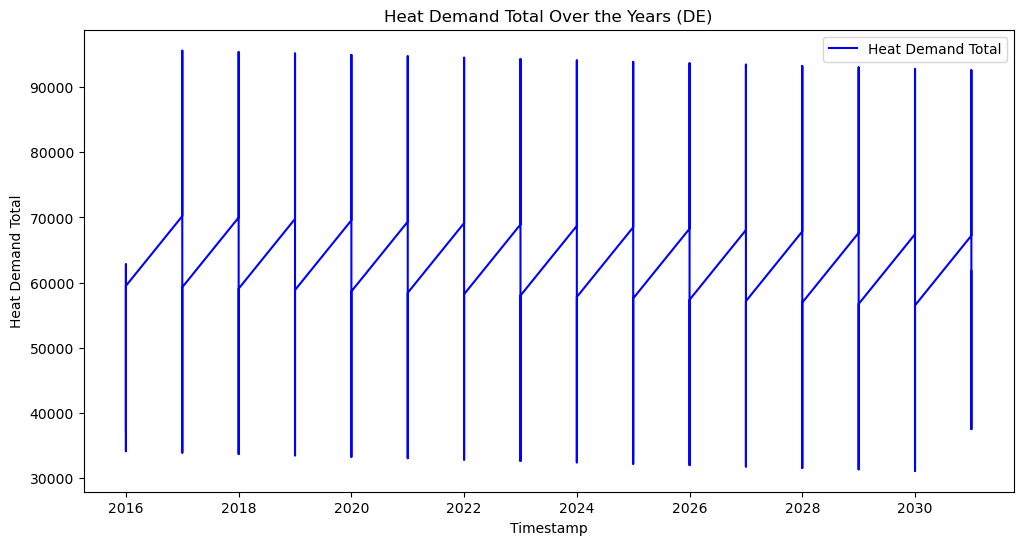

In [42]:
import matplotlib.pyplot as plt

# Assuming 'country_dfs' is the dictionary containing DataFrames for different countries
# and 'DE' is the country code for Germany

# Specify the country code for which you want to plot the predictions
country_code = 'DE'  # Change it to the desired country code

# Check if DE DataFrame exists
if 'DE_predicted_df' in country_predicted_dfs:
    # Extract DE DataFrame
    de_df = country_predicted_dfs['DE_predicted_df']

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(de_df['year'], de_df['heat_demand_total'], label='Heat Demand Total', color='blue')
    plt.title('Heat Demand Total Over the Years (DE)')
    plt.xlabel('Timestamp')
    plt.ylabel('Heat Demand Total')
    plt.legend()
    plt.show()
else:
    print("No DataFrame found for DE. Please make sure it exists in the 'country_dfs' dictionary.")


In [37]:
import os

# Replace 'output_folder' with the desired folder path
output_folder = '/Downloads/predicted_final_final'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Save each predicted DataFrame as a CSV file in the output folder
for country_code, predicted_df in country_predicted_dfs.items():
    # Create the file path for the CSV file
    file_path = os.path.join(output_folder, f"{country_code}_predicted_df.csv")

    # Save the DataFrame to the CSV file
    predicted_df.to_csv(file_path, index=False)

    print(f"Saved predicted DataFrame for {country_code} to {file_path}")


Saved predicted DataFrame for EE_predicted_df to /Users/meetsmacbook/Downloads/predicted_final_final/EE_predicted_df_predicted_df.csv
Saved predicted DataFrame for CZ_predicted_df to /Users/meetsmacbook/Downloads/predicted_final_final/CZ_predicted_df_predicted_df.csv
Saved predicted DataFrame for DK_predicted_df to /Users/meetsmacbook/Downloads/predicted_final_final/DK_predicted_df_predicted_df.csv
Saved predicted DataFrame for BE_predicted_df to /Users/meetsmacbook/Downloads/predicted_final_final/BE_predicted_df_predicted_df.csv
Saved predicted DataFrame for LV_predicted_df to /Users/meetsmacbook/Downloads/predicted_final_final/LV_predicted_df_predicted_df.csv
Saved predicted DataFrame for AT_predicted_df to /Users/meetsmacbook/Downloads/predicted_final_final/AT_predicted_df_predicted_df.csv
Saved predicted DataFrame for BG_predicted_df to /Users/meetsmacbook/Downloads/predicted_final_final/BG_predicted_df_predicted_df.csv
Saved predicted DataFrame for LT_predicted_df to /Users/meetsm